# Seismic deconvolution: one problem, many (possible) solutions

**Author: M. Ravasi, KAUST**

Welcome to our first tutorial at Transform2022!

The aim of this tutorial is to 

- Discuss a well-known and well studied problem in signal processing (and geophysics), namely seismic deconvolution;

- Showcase a number of alternative solutions discussing their pros and cons
- As a by-product of the above, show how different libraries in the Python ecosystem (e.g., NumPy/SciPy, PyLops, PyProximal, PyTorch) can be used to solve such a problem

## Useful links

- Tutorial Github repository: https://github.com/PyLops/pylops_transform2022
        
- PyLops Github repository: https://github.com/PyLops/pylops

- PyLops reference documentation: https://pylops.readthedocs.io/en/latest/

## Theory in a nutshell

In this tutorial we will try to keep the theory to a minimum and quickly expose you to practical examples. However, we want to make sure that some of the basic underlying concepts are clear to everyone and define a common mathematical notation.

<img src="figs/Convmodel.png" width="600">

...


We will consider the following possible ways of solving this problem:

-
-
-
-
-


Let's first import the libraries we need in this tutorial

In [1]:
# Run this when using Colab (will install the missing libraries)
# !pip install pylops==1.18.0 pylops-gpu pyproximal

In [2]:
%matplotlib inline

import random
import numpy as np
import matplotlib.pyplot as plt
import pylops
import pyproximal
import torch
import torch.nn as nn

from IPython.core.display import HTML
from scipy.sparse.linalg import lsqr
from torch.utils.data import TensorDataset, DataLoader
from tqdm.notebook import tqdm
from pylops.utils.wavelets import ricker
from pylops.utils import dottest
from pylops.optimization.solver import lsqr as lsqr_pylops
from pylops_gpu import TorchOperator

In [3]:
# Center figures
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

## Data creation

/opt/anaconda3/envs/pylops_t22/lib/python3.7/site-packages/pylops/utils/wavelets.py:31: UserWarning: one sample removed from time axis...
  warnings.warn("one sample removed from time axis...")


Dot test passed, v^T(Opu)=-9.781728 - u^T(Op^Tv)=-9.781728


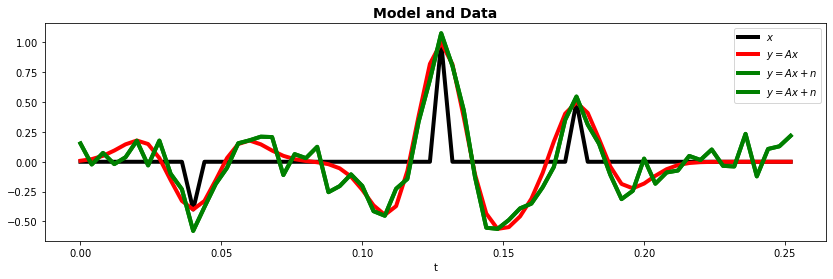

In [4]:
# Model
nt = 64
dt = 0.004
f0=20

t = np.arange(nt) * dt
x = np.zeros(nt)
x[10] = -0.4
x[int(nt / 2)] = 1
x[nt - 20] = 0.5

# Operator
h, th, hcenter = pylops.utils.wavelets.ricker(t[:101], f0=f0)
Cop = pylops.signalprocessing.Convolve1D(nt, h=h, offset=hcenter, dtype="float32")
dottest(Cop, verb=True)

# Data
y = Cop * x
yn = y + np.random.normal(0, 0.1, y.shape)

fig, ax = plt.subplots(1, 1, figsize=(14, 4))
ax.plot(t, x, "k", lw=4, label=r"$x$")
ax.plot(t, y, "r", lw=4, label=r"$y=Ax$")
ax.plot(t, yn, "g", lw=4, label=r"$y=Ax + n$")
ax.plot(t, yn, "g", lw=4, label=r"$y=Ax + n$")
ax.set_xlabel("t")
ax.set_title("Model and Data", fontsize=14, fontweight="bold")
ax.legend();

## Frequency domain decon

## Time domain decon

Overall theory

### Least-squares solution

Theory...

In [5]:
def callback(x, xtrue, err):
    return err.append(np.linalg.norm(x- xtrue))

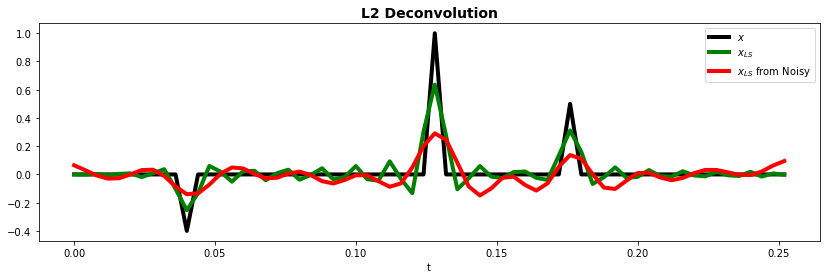

In [6]:
#xls = Cop / y
#xnls = Cop / yn
#xls = lsqr(Cop, y, damp=1e-10, iter_lim=1000, show=0)[0]
#xnls = lsqr(Cop, yn, damp=1e-1, iter_lim=1000, show=0)[0]

errls, errnls = [], []
xls = lsqr_pylops(Cop, y, np.zeros(nt), damp=1e-10, atol=0, btol=0, niter=400, show=0, 
                  callback=lambda X: callback(X, x, errls))[0]
xnls = lsqr_pylops(Cop, yn, np.zeros(nt), damp=8e-1, atol=0, btol=0, niter=400, show=0, 
                   callback=lambda X: callback(X, x, errnls))[0]

#xnls = pylops.optimization.leastsquares.RegularizedInversion(
#    Cop, [], yn, returninfo=False, **dict(damp=1e-1, atol=1e-3, iter_lim=100, show=0))


fig, ax = plt.subplots(1, 1, figsize=(14, 4))
ax.plot(t, x, "k", lw=4, label=r"$x$")
ax.plot(t, xls, "g", lw=4, label=r"$x_{LS}$")
ax.plot(t, xnls, "r", lw=4, label=r"$x_{LS}$ from Noisy")
ax.set_xlabel("t")
ax.set_title("L2 Deconvolution", fontsize=14, fontweight="bold")
ax.legend();

### Sparse solution

Theory of L1 regularized inversion... we can have 3 examples:
    
- Greedy algs (OMP)
- Iterative-thresh algs (ISTA, FISTA)
- Connect them to overall theory of Proximal algs (Proximal grad)
- AFISTA

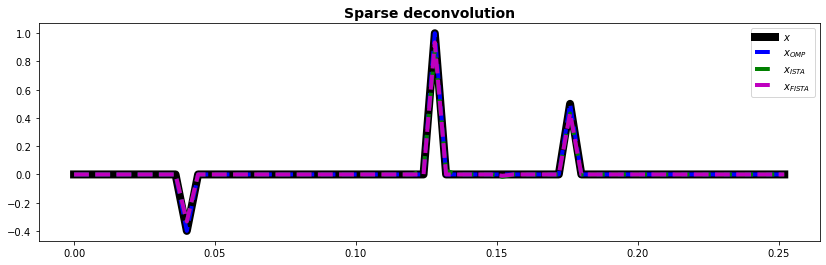

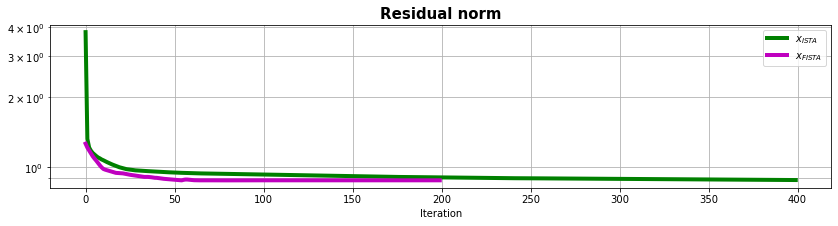

In [7]:
# noise-free
xomp, _, resomp = pylops.optimization.sparsity.OMP(
    Cop, y, niter_outer=10, sigma=1e-8)

errista, errfista = [], []
xista, _, resista = pylops.optimization.sparsity.ISTA(
    Cop, y, niter=400, eps=5e-1, tol=1e-8, returninfo=True, 
    callback=lambda X: callback(X, x, errista))

xfista, _, resfista = pylops.optimization.sparsity.FISTA(
    Cop, y, niter=200, eps=5e-1, tol=1e-8, returninfo=True, 
    callback=lambda X: callback(X, x, errfista))

fig, ax = plt.subplots(1, 1, figsize=(14, 4))
ax.plot(t, x, "k", lw=8, label=r"$x$")
ax.plot(t, xomp, "--b", lw=4, label=r"$x_{OMP}$")
ax.plot(t, xista, "--g", lw=4, label=r"$x_{ISTA}$")
ax.plot(t, xfista, "--m", lw=4, label=r"$x_{FISTA}$")
ax.set_title("Sparse deconvolution", fontsize=14, fontweight="bold")
ax.legend();

fig, ax = plt.subplots(1, 1, figsize=(14, 3))
ax.semilogy(resista, "g", lw=4, label=r"$x_{ISTA}$")
ax.semilogy(resfista, "m", lw=4, label=r"$x_{FISTA}$")
ax.set_title("Residual norm", size=15, fontweight="bold")
ax.set_xlabel("Iteration")
ax.legend()
ax.grid(True, which="both")

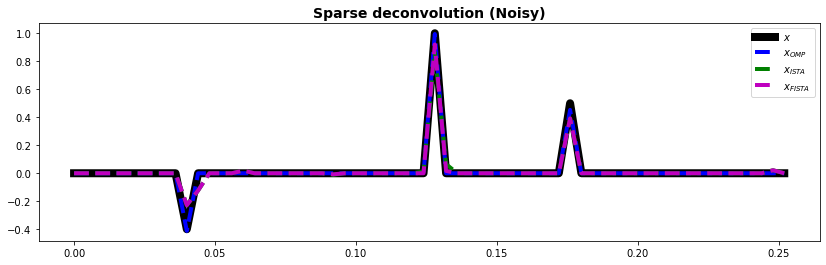

In [8]:
# noisy
xnomp, _, resomp = pylops.optimization.sparsity.OMP(
    Cop, yn, niter_outer=10, sigma=1e0, show=0)

errnista, errnfista = [], []
xnista, _, resista = pylops.optimization.sparsity.ISTA(
    Cop, yn, niter=400, eps=5e-1, tol=1e-8, returninfo=True, 
    callback=lambda X: callback(X, x, errnista))

xnfista, _, resfista = pylops.optimization.sparsity.FISTA(
    Cop, yn, niter=200, eps=5e-1, tol=1e-8, returninfo=True, 
    callback=lambda X: callback(X, x, errnfista))

fig, ax = plt.subplots(1, 1, figsize=(14, 4))
ax.plot(t, x, "k", lw=8, label=r"$x$")
ax.plot(t, xnomp, "--b", lw=4, label=r"$x_{OMP}$")
ax.plot(t, xnista, "--g", lw=4, label=r"$x_{ISTA}$")
ax.plot(t, xnfista, "--m", lw=4, label=r"$x_{FISTA}$")
ax.set_title("Sparse deconvolution (Noisy)", fontsize=14, fontweight="bold")
ax.legend();

In [9]:
# Proximal
l1 = pyproximal.proximal.L1()
l2 = pyproximal.proximal.L2(Op=Cop, b=y)
L = np.abs((Cop.H * Cop).eigs(1)[0])
tau = 0.95/L
eps = 5e-1 * 0.5 # to compensate for 0.5 in ISTA: thresh = eps * alpha * 0.5

errpista, errpfista = [], []
xista = pyproximal.optimization.primal.ProximalGradient(
                l2, l1, tau=tau, 
                x0=np.zeros(nt), 
                epsg=eps, niter=400,
                callback=lambda X: callback(X, x, errpista))

xfista = pyproximal.optimization.primal.AcceleratedProximalGradient(
                l2, l1, tau=tau, 
                x0=np.zeros(nt), acceleration='fista',
                epsg=eps, niter=200,
                callback=lambda X: callback(X, x, errpfista))

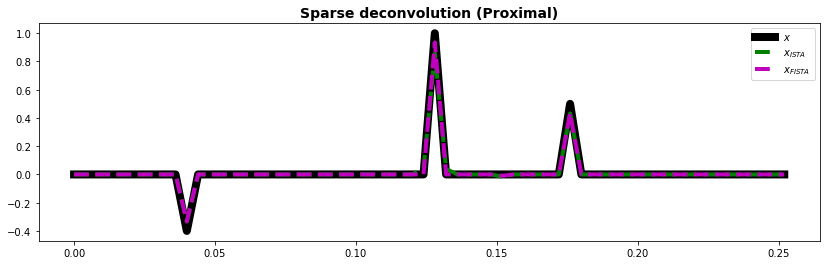

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(14, 4))
ax.plot(t, x, "k", lw=8, label=r"$x$")
ax.plot(t, xista, "--g", lw=4, label=r"$x_{ISTA}$")
ax.plot(t, xfista, "--m", lw=4, label=r"$x_{FISTA}$")
ax.set_title("Sparse deconvolution (Proximal)", fontsize=14, fontweight="bold")
ax.legend();

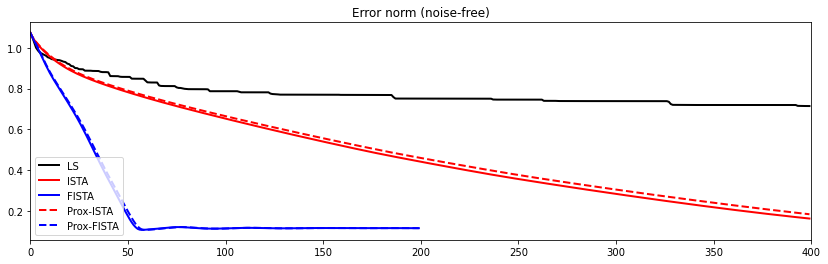

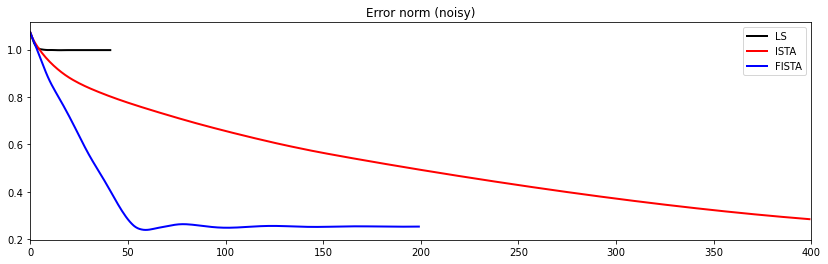

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(14, 4))
plt.plot(errls, 'k', lw=2, label='LS')
plt.plot(errista, 'r', lw=2, label='ISTA')
plt.plot(errfista, 'b', lw=2, label='FISTA')
plt.plot(errpista, '--r', lw=2, label='Prox-ISTA')
plt.plot(errpfista, '--b', lw=2, label='Prox-FISTA')
ax.set_title('Error norm (noise-free)')
ax.set_xlim(0, 400)
ax.legend()

fig, ax = plt.subplots(1, 1, figsize=(14, 4))
plt.plot(errnls, 'k',lw=2, label='LS')
plt.plot(errnista, 'r', lw=2, label='ISTA')
plt.plot(errnfista, 'b', lw=2, label='FISTA')
ax.set_title('Error norm (noisy)')
ax.set_xlim(0, 400)
ax.legend();

## Autograd-style

In [12]:
# Operator
Cop_torch = TorchOperator(Cop, pylops=True)

# Data
ytorch = torch.from_numpy(y).float()
#ytorch = torch.from_numpy(yn).float()

# Model
xad = torch.zeros(nt, dtype=torch.float)
xad.requires_grad = True

# Optimizer
optimizer = torch.optim.SGD([xad], lr=1e-3, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True)

# Optimization with L1 norm
niters = 10000
eps = 1e-2
loss_history = []
for i in range(niters):
    optimizer.zero_grad()
    ypred = Cop_torch.apply(xad)
    loss = torch.mean((ytorch-ypred)**2)
    loss.backward()
    optimizer.step()
        
    # update learning rate
    if scheduler is not None:
        scheduler.step(loss)
    
    # logging
    loss_history.append(loss.item())
    if i % 1000 == 99:
        print(f'Iteration {i}, Functional value: {loss.item():.5f}')

Iteration 99, Functional value: 0.02580
Iteration 1099, Functional value: 0.00167
Iteration 2099, Functional value: 0.00088
Iteration 3099, Functional value: 0.00053
Iteration 4099, Functional value: 0.00035
Iteration 5099, Functional value: 0.00026
Iteration 6099, Functional value: 0.00020
Iteration 7099, Functional value: 0.00016
Iteration 8099, Functional value: 0.00014
Iteration 9099, Functional value: 0.00012


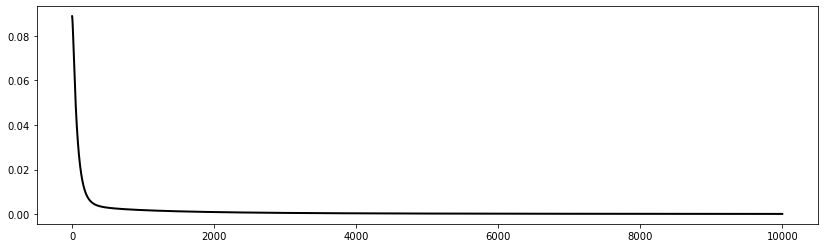

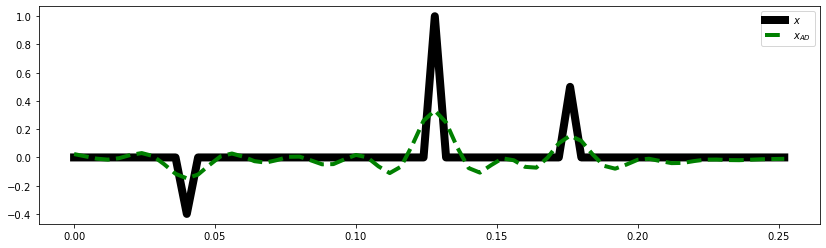

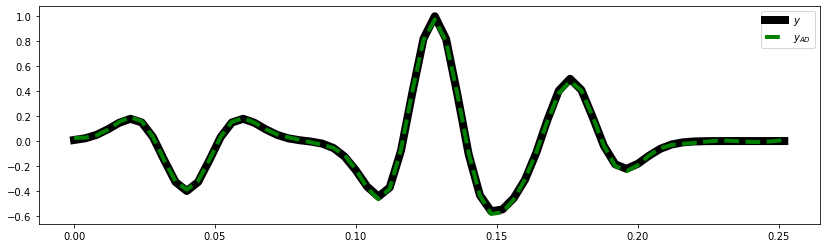

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(14, 4))
ax.plot(loss_history, 'k', lw=2)

fig, ax = plt.subplots(1, 1, figsize=(14, 4))
ax.plot(t, x, "k", lw=8, label=r"$x$")
ax.plot(t, xad.detach().numpy(), "--g", lw=4, label=r"$x_{AD}$")
ax.legend()

fig, ax = plt.subplots(1, 1, figsize=(14, 4))
ax.plot(t, y, "k", lw=8, label=r"$y$")
ax.plot(t, ypred.detach().numpy(), "--g", lw=4, label=r"$y_{AD}$")
ax.legend();

In [14]:
# Data
ytorch = torch.from_numpy(y).float()
#ytorch = torch.from_numpy(yn).float()

# Model
xad = torch.zeros(nt, dtype=torch.float)
xad.requires_grad = True

# Optimizer
optimizer = torch.optim.SGD([xad], lr=1e-3, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True)

# Optimization with L1 norm
niters = 10000
eps = 1e-2
loss_history = []
for i in range(niters):
    optimizer.zero_grad()
    ypred = Cop_torch.apply(xad)
    lossd = torch.mean((ytorch-ypred)**2)
    reg = torch.sum(torch.abs(xad))
    loss = lossd + eps * reg
    loss.backward()
    optimizer.step()
        
    # update learning rate
    if scheduler is not None:
        scheduler.step(loss)
    
    # logging
    loss_history.append(loss.item())
    if i % 1000 == 99:
        print(f'Iteration {i}, Functional value: {loss.item():.5f}')

Iteration 99, Functional value: 0.04283
Iteration 1099, Functional value: 0.02257
Iteration 2099, Functional value: 0.02076
Iteration 3099, Functional value: 0.02000
Epoch  3389: reducing learning rate of group 0 to 1.0000e-04.
Epoch  3416: reducing learning rate of group 0 to 1.0000e-05.
Epoch  3427: reducing learning rate of group 0 to 1.0000e-06.
Epoch  3439: reducing learning rate of group 0 to 1.0000e-07.
Epoch  3450: reducing learning rate of group 0 to 1.0000e-08.
Iteration 4099, Functional value: 0.01989
Iteration 5099, Functional value: 0.01989
Iteration 6099, Functional value: 0.01989
Iteration 7099, Functional value: 0.01989
Iteration 8099, Functional value: 0.01989
Iteration 9099, Functional value: 0.01989


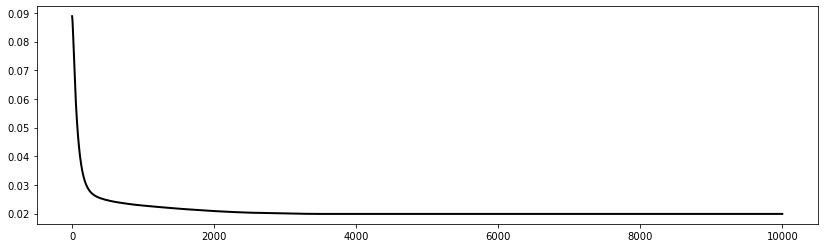

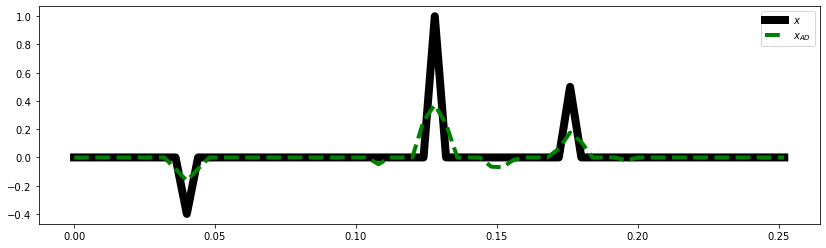

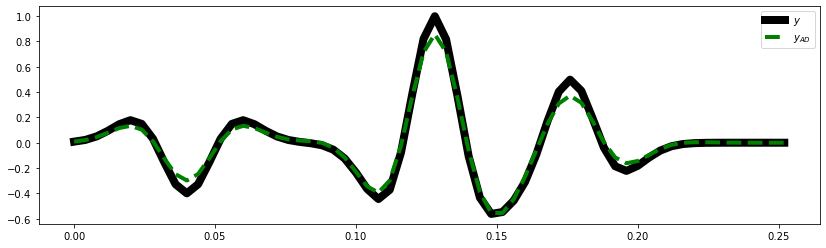

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(14, 4))
ax.plot(loss_history, 'k', lw=2)

fig, ax = plt.subplots(1, 1, figsize=(14, 4))
ax.plot(t, x, "k", lw=8, label=r"$x$")
ax.plot(t, xad.detach().numpy(), "--g", lw=4, label=r"$x_{AD}$")
ax.legend()

fig, ax = plt.subplots(1, 1, figsize=(14, 4))
ax.plot(t, y, "k", lw=8, label=r"$y$")
ax.plot(t, ypred.detach().numpy(), "--g", lw=4, label=r"$y_{AD}$")
ax.legend();

## Data-driven

Let's first create a large number of training samples

In [16]:
def set_seed(seed):
    """Set all random seeds to a fixed value and take out any
    randomness from cuda kernels
    Parameters
    ----------
    seed : :obj:`int`
        Seed number
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False

    return True

In [17]:
def weights_init(m):
    """Initialize weights
    """
    if isinstance(m, nn.Conv1d) or isinstance(m, nn.ConvTranspose1d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm1d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)


class ContractingBlock(nn.Module):
    """Contracting block

    Single block in contracting path composed of two convolutions followed by a max pool operation.
    We allow also to optionally include a batch normalization and dropout step.

    Parameters
    ----------
    input_channels : :obj:`int`
        Number of input channels
    use_dropout : :obj:`bool`, optional
        Add dropout
    use_bn : :obj:`bool`, optional
        Add batch normalization

    """
    def __init__(self, input_channels, use_dropout=False, use_bn=True):
        super(ContractingBlock, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, input_channels * 2, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(input_channels * 2, input_channels * 2, kernel_size=3, padding=1)
        self.activation = nn.LeakyReLU(0.2)
        self.maxpool = nn.MaxPool1d(kernel_size=2, stride=2)
        if use_bn:
            self.batchnorm = nn.BatchNorm1d(input_channels * 2, momentum=0.8)
        self.use_bn = use_bn
        if use_dropout:
            self.dropout = nn.Dropout()
        self.use_dropout = use_dropout

    def forward(self, x):
        x = self.conv1(x)
        if self.use_bn:
            x = self.batchnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.activation(x)
        x = self.conv2(x)
        if self.use_bn:
            x = self.batchnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.activation(x)
        x = self.maxpool(x)
        return x


class ExpandingBlock(nn.Module):
    """Expanding block

    Single block in expanding path composed of an upsampling layer, a convolution, a concatenation of
    its output with the features at the same level in the contracting path, two additional convolutions.
    We allow also to optionally include a batch normalization and dropout step.

    Parameters
    ----------
    input_channels : :obj:`int`
        Number of input channels
    use_dropout : :obj:`bool`, optional
        Add dropout
    use_bn : :obj:`bool`, optional
        Add batch normalization

    """
    def __init__(self, input_channels, use_dropout=False, use_bn=True):
        super(ExpandingBlock, self).__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')#, align_corners=False)
        self.conv1 = nn.Conv1d(input_channels, input_channels // 2, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(input_channels, input_channels // 2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(input_channels // 2, input_channels // 2, kernel_size=3, padding=1)
        if use_bn:
            self.batchnorm = nn.BatchNorm1d(input_channels // 2, momentum=0.8)
        self.use_bn = use_bn
        self.activation = nn.ReLU()
        if use_dropout:
            self.dropout = nn.Dropout()
        self.use_dropout = use_dropout

    def forward(self, x, skip_con_x):
        x = self.upsample(x)
        x = self.conv1(x)
        x = torch.cat([x, skip_con_x], axis=1)
        x = self.conv2(x)
        if self.use_bn:
            x = self.batchnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.activation(x)
        x = self.conv3(x)
        if self.use_bn:
            x = self.batchnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.activation(x)
        return x


class FeatureMapBlock(nn.Module):
    """Feature Map block

    Final layer of U-Net which restores for the output channel dimensions to those of the input (or any other size)
    using a 1x1 convolution.

    Parameters
    ----------
    input_channels : :obj:`int`
        Number of input channels
    output_channels : :obj:`int`
        Number of output channels

    """
    def __init__(self, input_channels, output_channels):
        super(FeatureMapBlock, self).__init__()
        self.conv = nn.Conv1d(input_channels, output_channels, kernel_size=1)

    def forward(self, x):
        x = self.conv(x)
        return x


class UNet(nn.Module):
    """UNet architecture

    UNet architecture composed of a series of contracting blocks followed by expanding blocks.

    Most UNet implementations available online hard-code a certain number of levels. Here,
    the number of levels for the contracting and expanding paths can be defined by the user and the
    UNet is built in such a way that the same code can be used for any number of levels without modification.

    Parameters
    ----------
    input_channels : :obj:`int`
        Number of input channels
    output_channels : :obj:`int`, optional
        Number of output channels
    hidden_channels : :obj:`int`, optional
        Number of hidden channels of first layer
    levels : :obj:`int`, optional
        Number of levels in encoding and deconding paths

    """
    def __init__(self, input_channels=1, output_channels=1, hidden_channels=64, levels=2):
        super(UNet, self).__init__()
        self.levels = levels
        self.upfeature = FeatureMapBlock(input_channels, hidden_channels)
        self.contract = []
        self.expand = []
        for level in range(levels):
            self.contract.append(ContractingBlock(hidden_channels * (2 ** level), 
                                                  use_dropout=False, use_bn=False))
        for level in range(levels):
            self.expand.append(ExpandingBlock(hidden_channels * (2 ** (levels - level)), 
                                              use_dropout=False, use_bn=False))
        self.contracts = nn.Sequential(*self.contract)
        self.expands = nn.Sequential(*self.expand)
        self.downfeature = FeatureMapBlock(hidden_channels, output_channels)

    def forward(self, x):
        xenc = []
        x = self.upfeature(x)
        xenc.append(x)
        for level in range(self.levels):
            x = self.contract[level](x)
            xenc.append(x)
        for level in range(self.levels):
            x = self.expand[level](x, xenc[self.levels - level - 1])
        xn = self.downfeature(x)
        return xn

In [18]:
def train(model, criterion, optimizer, data_loader, device='cpu', plotflag=False):
    """Training step

    Perform a training step over the entire training data (1 epoch of training)

    Parameters
    ----------
    model : :obj:`torch.nn.Module`
        Model
    criterion : :obj:`torch.nn.modules.loss`
        Loss function
    optimizer : :obj:`torch.optim`
        Optimizer
    data_loader : :obj:`torch.utils.data.dataloader.DataLoader`
        Training dataloader
    device : :obj:`str`, optional
        Device
    plotflag : :obj:`bool`, optional
        Display intermediate results

    Returns
    -------
    loss : :obj:`float`
        Loss over entire dataset
    accuracy : :obj:`float`
        Accuracy over entire dataset

    """
    model.train()
    loss = 0
    for X, y in data_loader:#tqdm(data_loader):
        optimizer.zero_grad()
        X, y = X.unsqueeze(1), y.unsqueeze(1)
        ypred = model(X)
        ls = criterion(ypred.view(-1), y.view(-1))
        ls.backward()
        optimizer.step()
        loss += ls.item()
    loss /= len(data_loader)
    
    if plotflag:
        fig, ax = plt.subplots(1, 1, figsize=(14, 4))
        ax.plot(t, y.detach().squeeze()[:5].T, "k")
        ax.plot(t, ypred.detach().squeeze()[:5].T, "r")
        ax.set_xlabel("t")
        plt.show()
    
    return loss


def evaluate(model, criterion, data_loader, device='cpu', plotflag=False):
    """Evaluation step

    Perform an evaluation step over the entire training data

    Parameters
    ----------
    model : :obj:`torch.nn.Module`
        Model
    criterion : :obj:`torch.nn.modules.loss`
        Loss function
    data_loader : :obj:`torch.utils.data.dataloader.DataLoader`
        Evaluation dataloader
    device : :obj:`str`, optional
        Device
    plotflag : :obj:`bool`, optional
        Display intermediate results

    Returns
    -------
    loss : :obj:`float`
        Loss over entire dataset
    accuracy : :obj:`float`
        Accuracy over entire dataset

    """
    model.train()  # not eval because https://github.com/facebookresearch/SparseConvNet/issues/166
    loss = 0
    for X, y in data_loader:#tqdm(data_loader):
        X, y = X.unsqueeze(1), y.unsqueeze(1)
        with torch.no_grad():
            ypred = model(X)
            ls = criterion(ypred.view(-1), y.view(-1))
        loss += ls.item()
    loss /= len(data_loader)
    
    if plotflag:
        fig, ax = plt.subplots(1, 1, figsize=(14, 4))
        ax.plot(t, y.detach().squeeze()[:5].T, "k")
        ax.plot(t, ypred.detach().squeeze()[:5].T, "r")
        ax.set_xlabel("t")
        plt.show()
    
    return loss


def predict(model, X, device='cpu'):
    """Prediction step

    Perform a prediction over a batch of input samples

    Parameters
    ----------
    model : :obj:`torch.nn.Module`
        Model
    X : :obj:`torch.tensor`
        Inputs
    X : :obj:`torch.tensor`
        Masks
    device : :obj:`str`, optional
        Device

    """
    model.train() # not eval because https://github.com/facebookresearch/SparseConvNet/issues/166
    with torch.no_grad():
        ypred = model(X)
    return ypred

In [19]:
def create_reflectivity_and_data(nspikes, ampmax, nt, twav, f0=20):
    nsp = np.random.randint(nspikes[0], nspikes[1])
    spikes = np.random.uniform(10, nt-10, size=nsp).astype(int)
    amps = np.random.uniform(-ampmax, ampmax, size=nsp)
    x = np.zeros(nt)
    x[spikes] = amps
    h, th, hcenter = pylops.utils.wavelets.ricker(twav, f0=f0)
    Cop = pylops.signalprocessing.Convolve1D(nt, h=h, offset=hcenter, dtype="float32")
    y = Cop * x

    #h1, th, hcenter1 = pylops.utils.wavelets.ricker(twav, f0=f0+10)
    #C1op = pylops.signalprocessing.Convolve1D(nt, h=h1, offset=hcenter1, dtype="float32")
    #x = C1op * x
    return x, y

/opt/anaconda3/envs/pylops_t22/lib/python3.7/site-packages/pylops/utils/wavelets.py:31: UserWarning: one sample removed from time axis...
  warnings.warn("one sample removed from time axis...")


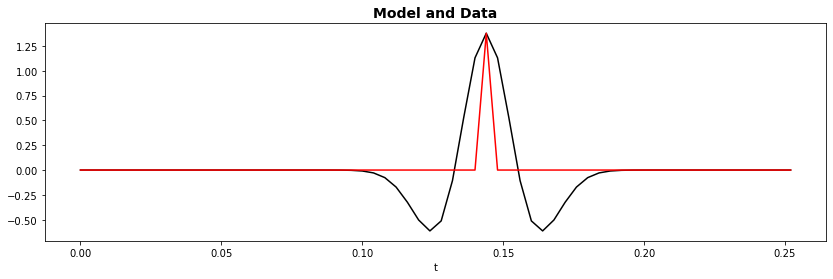

In [20]:
set_seed(0)
    
# Train data
ntrain = 2**8
X_train = np.zeros((ntrain, nt))
y_train = np.zeros((ntrain, nt))
for i in range(ntrain):
    y_train[i], X_train[i] = create_reflectivity_and_data((1,4), 2, nt=nt, twav=t[:101], f0=f0)
    
# Train data
ntrain = 100
X_test = np.zeros((ntrain, nt))
y_test = np.zeros((ntrain, nt))
for i in range(ntrain):
    y_test[i], X_test[i] = create_reflectivity_and_data((1,4), 2, nt=nt, twav=t[:101], f0=f0)

fig, ax = plt.subplots(1, 1, figsize=(14, 4))
ax.plot(t, X_train[0].T, "k")
ax.plot(t, y_train[0].T, "r")
ax.set_xlabel("t")
ax.set_title("Model and Data", fontsize=14, fontweight="bold");

In [21]:
# Convert Train Set to Torch
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
train_dataset = TensorDataset(X_train, y_train)

# Convert Test Set to Torch
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()
test_dataset = TensorDataset(X_test, y_test)

# Use Pytorch's functionality to load data in batches.
batch_size=64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) 

In [22]:
network = UNet(1, 1, hidden_channels=32)
#network = network.apply(weights_init) 
print(network)

UNet(
  (upfeature): FeatureMapBlock(
    (conv): Conv1d(1, 32, kernel_size=(1,), stride=(1,))
  )
  (contracts): Sequential(
    (0): ContractingBlock(
      (conv1): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (activation): LeakyReLU(negative_slope=0.2)
      (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): ContractingBlock(
      (conv1): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (conv2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (activation): LeakyReLU(negative_slope=0.2)
      (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (expands): Sequential(
    (0): ExpandingBlock(
      (upsample): Upsample(scale_factor=2.0, mode=nearest)
      (conv1): Conv1d(128, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (conv2): Conv1d(128, 64, k

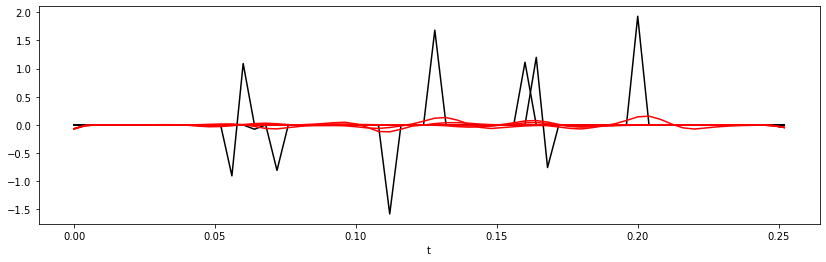

Epoch 0, Training Loss 0.05, Test Loss 0.04
Epoch 1, Training Loss 0.04, Test Loss 0.04
Epoch 2, Training Loss 0.03, Test Loss 0.03
Epoch 3, Training Loss 0.03, Test Loss 0.03
Epoch 4, Training Loss 0.03, Test Loss 0.03
Epoch 5, Training Loss 0.03, Test Loss 0.03
Epoch 6, Training Loss 0.03, Test Loss 0.03
Epoch 7, Training Loss 0.03, Test Loss 0.03
Epoch 8, Training Loss 0.03, Test Loss 0.03
Epoch 9, Training Loss 0.02, Test Loss 0.03


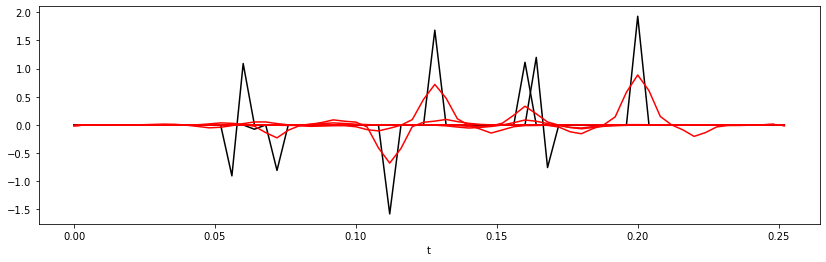

Epoch 10, Training Loss 0.02, Test Loss 0.03
Epoch 11, Training Loss 0.02, Test Loss 0.02
Epoch 12, Training Loss 0.02, Test Loss 0.02
Epoch 13, Training Loss 0.02, Test Loss 0.02
Epoch 14, Training Loss 0.02, Test Loss 0.02
Epoch 15, Training Loss 0.02, Test Loss 0.02
Epoch 16, Training Loss 0.02, Test Loss 0.02
Epoch 17, Training Loss 0.01, Test Loss 0.02
Epoch 18, Training Loss 0.01, Test Loss 0.01
Epoch 19, Training Loss 0.01, Test Loss 0.02


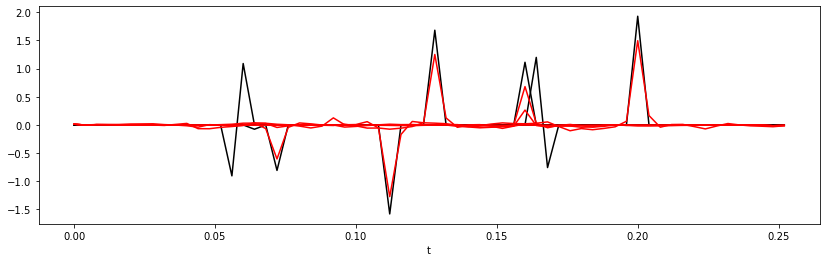

Epoch 20, Training Loss 0.01, Test Loss 0.01
Epoch 21, Training Loss 0.01, Test Loss 0.01
Epoch 22, Training Loss 0.01, Test Loss 0.01
Epoch 23, Training Loss 0.01, Test Loss 0.01
Epoch 24, Training Loss 0.01, Test Loss 0.01
Epoch 25, Training Loss 0.01, Test Loss 0.01
Epoch 26, Training Loss 0.01, Test Loss 0.01
Epoch 27, Training Loss 0.01, Test Loss 0.01
Epoch 28, Training Loss 0.01, Test Loss 0.01
Epoch 29, Training Loss 0.01, Test Loss 0.01


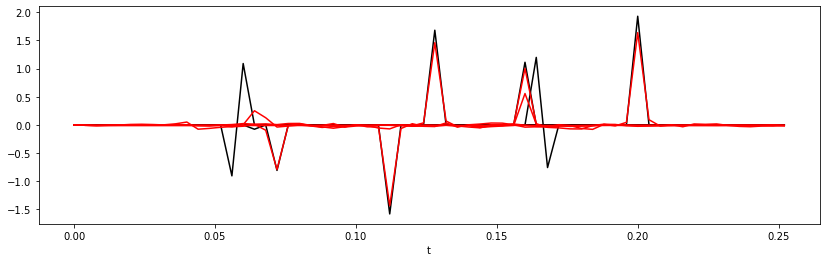

Epoch 30, Training Loss 0.01, Test Loss 0.01
Epoch 31, Training Loss 0.01, Test Loss 0.01
Epoch 32, Training Loss 0.01, Test Loss 0.01
Epoch 33, Training Loss 0.01, Test Loss 0.01
Epoch 34, Training Loss 0.01, Test Loss 0.01
Epoch 35, Training Loss 0.01, Test Loss 0.01
Epoch 36, Training Loss 0.01, Test Loss 0.01
Epoch 37, Training Loss 0.01, Test Loss 0.01
Epoch 38, Training Loss 0.01, Test Loss 0.01
Epoch 39, Training Loss 0.01, Test Loss 0.01


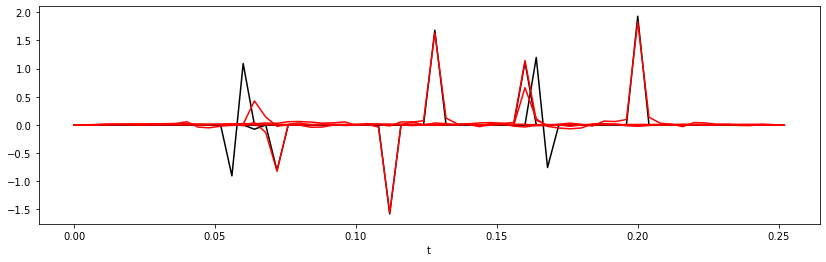

Epoch 40, Training Loss 0.01, Test Loss 0.01
Epoch 41, Training Loss 0.01, Test Loss 0.01
Epoch 42, Training Loss 0.01, Test Loss 0.01
Epoch 43, Training Loss 0.01, Test Loss 0.01
Epoch 44, Training Loss 0.01, Test Loss 0.01
Epoch 45, Training Loss 0.01, Test Loss 0.01
Epoch 46, Training Loss 0.01, Test Loss 0.01
Epoch 47, Training Loss 0.01, Test Loss 0.01
Epoch 48, Training Loss 0.01, Test Loss 0.01
Epoch 49, Training Loss 0.01, Test Loss 0.01


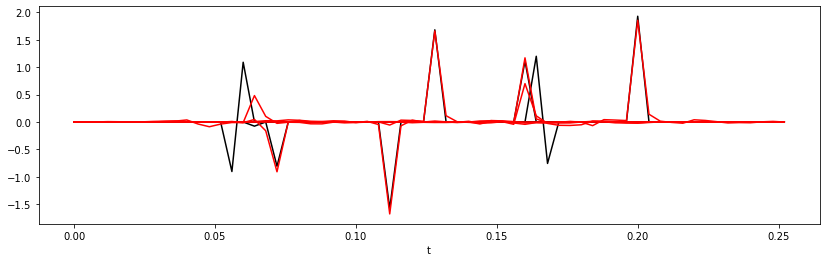

Epoch 50, Training Loss 0.01, Test Loss 0.01
Epoch 51, Training Loss 0.01, Test Loss 0.01
Epoch 52, Training Loss 0.01, Test Loss 0.01
Epoch 53, Training Loss 0.01, Test Loss 0.01
Epoch 54, Training Loss 0.01, Test Loss 0.01
Epoch 55, Training Loss 0.01, Test Loss 0.01
Epoch 56, Training Loss 0.01, Test Loss 0.01
Epoch 57, Training Loss 0.01, Test Loss 0.01
Epoch 58, Training Loss 0.01, Test Loss 0.01
Epoch 59, Training Loss 0.01, Test Loss 0.01


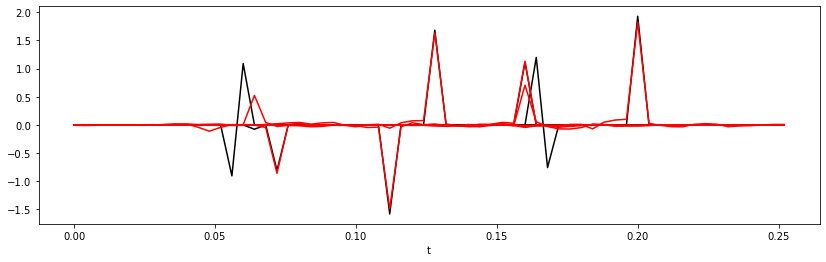

Epoch 60, Training Loss 0.01, Test Loss 0.01
Epoch 61, Training Loss 0.01, Test Loss 0.01
Epoch 62, Training Loss 0.01, Test Loss 0.01
Epoch 63, Training Loss 0.01, Test Loss 0.01
Epoch 64, Training Loss 0.00, Test Loss 0.01
Epoch 65, Training Loss 0.00, Test Loss 0.01
Epoch 66, Training Loss 0.00, Test Loss 0.01
Epoch 67, Training Loss 0.01, Test Loss 0.01
Epoch 68, Training Loss 0.00, Test Loss 0.01
Epoch 69, Training Loss 0.00, Test Loss 0.01


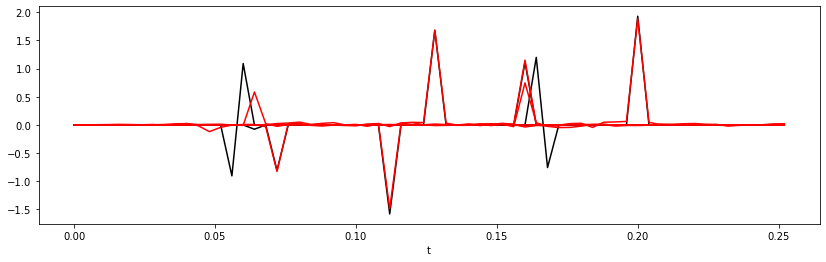

Epoch 70, Training Loss 0.00, Test Loss 0.01
Epoch 71, Training Loss 0.00, Test Loss 0.01
Epoch 72, Training Loss 0.00, Test Loss 0.01
Epoch 73, Training Loss 0.00, Test Loss 0.01
Epoch 74, Training Loss 0.00, Test Loss 0.01
Epoch 75, Training Loss 0.00, Test Loss 0.01
Epoch 76, Training Loss 0.00, Test Loss 0.01
Epoch 77, Training Loss 0.00, Test Loss 0.01
Epoch 78, Training Loss 0.00, Test Loss 0.01
Epoch 79, Training Loss 0.00, Test Loss 0.01


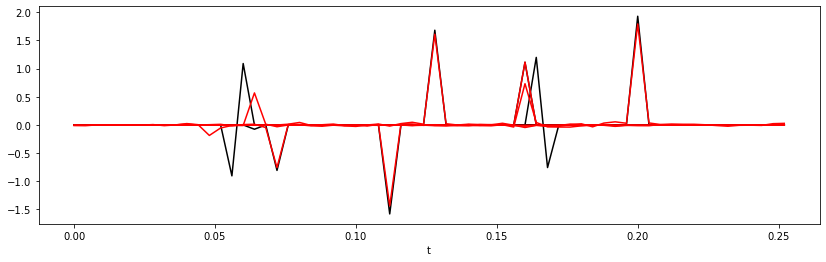

Epoch 80, Training Loss 0.00, Test Loss 0.01
Epoch 81, Training Loss 0.00, Test Loss 0.01
Epoch 82, Training Loss 0.00, Test Loss 0.01
Epoch 83, Training Loss 0.00, Test Loss 0.01
Epoch 84, Training Loss 0.00, Test Loss 0.01
Epoch 85, Training Loss 0.00, Test Loss 0.01
Epoch 86, Training Loss 0.00, Test Loss 0.01
Epoch 87, Training Loss 0.00, Test Loss 0.01
Epoch 88, Training Loss 0.00, Test Loss 0.01
Epoch 89, Training Loss 0.00, Test Loss 0.01


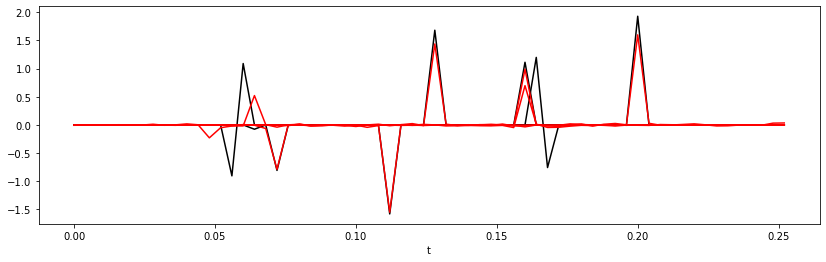

Epoch 90, Training Loss 0.00, Test Loss 0.01
Epoch 91, Training Loss 0.00, Test Loss 0.01
Epoch 92, Training Loss 0.00, Test Loss 0.01
Epoch 93, Training Loss 0.00, Test Loss 0.01
Epoch 94, Training Loss 0.00, Test Loss 0.01
Epoch 95, Training Loss 0.00, Test Loss 0.01
Epoch 96, Training Loss 0.00, Test Loss 0.01
Epoch 97, Training Loss 0.00, Test Loss 0.01
Epoch 98, Training Loss 0.00, Test Loss 0.01
Epoch 99, Training Loss 0.00, Test Loss 0.01


In [23]:
n_epochs = 100
lr = 1e-3

criterion = nn.MSELoss()
#criterion = nn.L1Loss()
optim = torch.optim.Adam(network.parameters(), lr=lr, weight_decay=1e-4)

train_loss_history = np.zeros(n_epochs)
test_loss_history = np.zeros(n_epochs)
for i in range(n_epochs):
    train_loss = train(network, criterion, optim, 
                       train_loader, device='cpu', 
                       plotflag=False)#True if i%10==0 else False)
    test_loss = evaluate(network, criterion, 
                         test_loader, device='cpu', 
                         plotflag=True if i%10==0 else False)
    train_loss_history[i]= train_loss
    test_loss_history[i] = test_loss
    print(f'Epoch {i}, Training Loss {train_loss:.2f}, Test Loss {test_loss:.2f}')

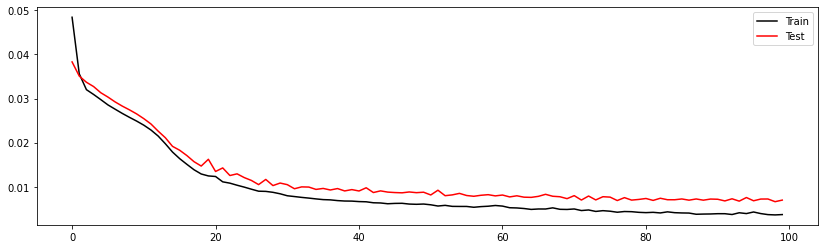

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(14, 4))
ax.plot(train_loss_history, "k", label='Train')
ax.plot(test_loss_history, "r", label='Test')
ax.legend();

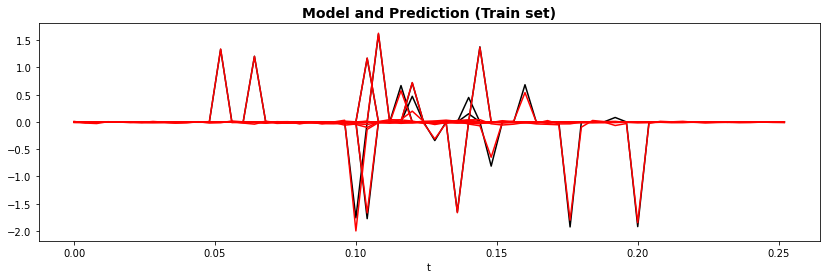

In [25]:
y_train_pred = predict(network, X_train[:10].unsqueeze(1), device='cpu').squeeze()

fig, ax = plt.subplots(1, 1, figsize=(14, 4))
ax.plot(t, y_train[:10].T, "k")
ax.plot(t, y_train_pred[:10].T, "r")
ax.set_xlabel("t")
ax.set_title("Model and Prediction (Train set)", fontsize=14, fontweight="bold");

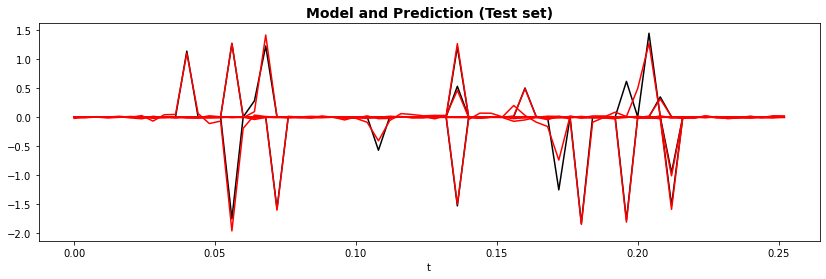

In [26]:
y_test_pred = predict(network, X_test[:10].unsqueeze(1), device='cpu').squeeze()

fig, ax = plt.subplots(1, 1, figsize=(14, 4))
ax.plot(t, y_test[:10].T, "k")
ax.plot(t, y_test_pred[:10].T, "r")
ax.set_xlabel("t")
ax.set_title("Model and Prediction (Test set)", fontsize=14, fontweight="bold");

## Conclusions